In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import os, math, random, time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
import torch.nn as nn
import torch
import torchvision
import torch.nn.functional as F
import torchvision.transforms as transforms
import torch.optim as optim
from collections import defaultdict

In [2]:
def timer_start():
    global t0
    t0 = time.time()
    
def timer_end():   
    print('Time elapsed {:0.1f}s'.format(time.time() - t0))  

def display_grid(data, path, w =10, h =10, columns = 4, rows = 5):
    fig=plt.figure(figsize=(12, 8))
    for i in range(1, columns*rows +1):
        file = data[i]
        file = os.path.join(path, file)
        img = Image.open(file)
        fig.add_subplot(rows, columns, i)
        imshow(img)
    plt.show()
    
def get_best_epcoh(history):
    valid_acc = history['val_acc']
    best_epoch = valid_acc.index(max(valid_acc)) +1
    best_acc =  max(valid_acc)
    print('Best Validation Accuracy Score {:0.5f}, is for epoch {}'.format( best_acc, best_epoch))
    return best_epoch

def plot_results(history):
    tr_acc = history['tr_acc']
    val_acc = history['val_acc']
    tr_loss = history['tr_loss']
    val_loss = history['val_loss']
    epochs = history['epoch']

    plt.figure(figsize = (24, 6))
    plt.subplot(1,2,1)
    plt.plot(epochs, tr_acc, 'b', label = 'Training Accuracy')
    plt.plot(epochs, val_acc, 'r', label = 'Validation Accuracy')
    plt.grid(True)
    plt.legend()
    plt.xlabel('Epoch')  
    
    plt.subplot(1,2,2)
    plt.plot(epochs, tr_loss, 'b', label = 'Training Loss')
    plt.plot(epochs, val_loss, 'r', label = 'Validation Loss')
    plt.grid(True)
    plt.legend()
    plt.xlabel('Epoch')
    plt.show()
    
def set_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    


In [3]:
base_dir = '/content/drive/MyDrive/Alzheimer/'
train = os.listdir(os.path.join(base_dir, 'train (2)') )
val  = os.listdir(os.path.join(base_dir, 'test (1)') )
print('Instances for Class Alzheimer: Train {}, Validation {}'.format(len(train), len(val)))

Instances for Class Alzheimer: Train 4, Validation 4


In [4]:
train_dir = os.path.join(base_dir, 'train (2)')
validation_dir = os.path.join(base_dir, 'test (1)' )

In [5]:
BATCH_SIZE = 32
transform = transforms.Compose( [                                  
                                 transforms.Resize((150,150)),
                                 transforms.RandomRotation(10),
                                 transforms.RandomHorizontalFlip(), 
                                 transforms.ToTensor(),
                                  ])

trainset = torchvision.datasets.ImageFolder( root= train_dir ,
                                              transform=transform
                                               )


trainloader = torch.utils.data.DataLoader(trainset, batch_size= BATCH_SIZE,
                                          shuffle=True, num_workers=4)


validset = torchvision.datasets.ImageFolder( root= validation_dir ,
                                              transform=transform
                                               )


validloader = torch.utils.data.DataLoader(validset , batch_size= BATCH_SIZE,
                                          shuffle=True, num_workers=4)



In [6]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, 3)
        self.conv3 = nn.Conv2d(16, 32, 3)
        self.conv5 = nn.Conv2d(32, 64, 3)
        self.conv7 = nn.Conv2d(64, 128, 3)
        self.conv8 = nn.Conv2d(128, 128, 3)
        self.pool = nn.MaxPool2d(2)
        self.flat = nn.Flatten()
        self.fc1 = nn.Linear(21632, 1024)
        self.fc2 = nn.Linear(1024, 128)
        self.fc3 = nn.Linear(128, 4)
        

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv5(x)))
        x = F.relu(self.conv7(x))
        x = F.relu(self.conv8(x))
        x = self.flat(x)
        x = F.leaky_relu(self.fc1(x))
        x = nn.Dropout(p=0.3)(x)
        x = F.leaky_relu(self.fc2(x))
        x = nn.Dropout(p=0.2)(x)
        x = torch.softmax(self.fc3(x),dim=1)
        return x

In [7]:
def train(model, epoch, train_loader, optimizer, criterion) :   
    model.train()
    epoch_loss = correct = 0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)    
        optimizer.zero_grad()
        outputs = model(inputs)


        loss =  criterion(outputs, labels)
        

        _, predicted = torch.max(outputs.data, 1)           


        correct += (predicted == labels).sum().item()  

        loss.backward()

        optimizer.step() 
        
        epoch_loss += outputs.shape[0] * loss.item()
        
    accuracy = correct / len(train_loader.dataset)
    epoch_loss = epoch_loss / len(train_loader.dataset)
    return epoch_loss, accuracy


def test(model, epoch, test_loader, optimizer, criterion):
    model.eval()
    epoch_loss = correct = 0

    with torch.no_grad():

        for i, data in enumerate(test_loader, 0):
            images, labels = data[0].to(device), data[1].to(device)

            outputs = model(images)


            loss =    criterion(outputs, labels)


            _, predicted = torch.max(outputs.data, 1)           
            correct += (predicted == labels).sum().item()  


            epoch_loss += outputs.shape[0] * loss.item()

    
    accuracy = correct / len(test_loader.dataset)
    epoch_loss = epoch_loss / len(test_loader.dataset)
  
    return epoch_loss, accuracy

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = Net()
model.to(device)


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)
print('Divice: ',device)
model

Divice:  cuda:0


Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv5): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv8): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flat): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=21632, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=4, bias=True)
)

In [9]:
%%time
EPOCHS = 200


train_list  = os.listdir(os.path.join(base_dir, 'train (2)/MildDemented') ) + os.listdir(os.path.join(base_dir, 'train (2)/ModerateDemented') ) + os.listdir(os.path.join(base_dir, 'train (2)/NonDemented') ) + os.listdir(os.path.join(base_dir, 'train (2)/VeryMildDemented') )
num_batches = math.ceil(len(train_list) / BATCH_SIZE)

print('Number of Training samples {}, Batch Size {}, Num Batch {}'.format( len(train_list), BATCH_SIZE, num_batches ))

history = defaultdict(list)


for epoch in range( EPOCHS):  
    timer_start()
    print('[Epoch {} of {}]'.format(epoch +1, EPOCHS), end = ' ')
    tr_loss, tr_acc = train(model, epoch, trainloader, optimizer, criterion)

    val_loss, val_acc = test(model, epoch, validloader, optimizer, criterion)  
    timer_end()
    print('tr_loss: {:0.4f},tr_acc {:0.4f}| val_loss {:0.4f}, val_acc {:0.4f}'.format(tr_loss, tr_acc , val_loss, val_acc))
    history['epoch'].append(epoch+1)
    history['tr_loss'].append(round(tr_loss,5))
    history['tr_acc'].append(round(tr_acc,5))
    history['val_loss'].append(round(val_loss,5))
    history['val_acc'].append(round(val_acc,5))

Number of Training samples 5121, Batch Size 32, Num Batch 161
[Epoch 1 of 200] Time elapsed 687.3s
tr_loss: 1.2389,tr_acc 0.4970| val_loss 1.2336, val_acc 0.5004
[Epoch 2 of 200] Time elapsed 13.3s
tr_loss: 1.2256,tr_acc 0.4999| val_loss 1.2223, val_acc 0.5004
[Epoch 3 of 200] Time elapsed 13.4s
tr_loss: 1.1967,tr_acc 0.5192| val_loss 1.1901, val_acc 0.5184
[Epoch 4 of 200] Time elapsed 13.6s
tr_loss: 1.1778,tr_acc 0.5388| val_loss 1.1986, val_acc 0.5238
[Epoch 5 of 200] Time elapsed 13.5s
tr_loss: 1.1742,tr_acc 0.5479| val_loss 1.1779, val_acc 0.5270
[Epoch 6 of 200] Time elapsed 13.5s
tr_loss: 1.1631,tr_acc 0.5575| val_loss 1.2025, val_acc 0.5199
[Epoch 7 of 200] Time elapsed 13.5s
tr_loss: 1.1595,tr_acc 0.5561| val_loss 1.2051, val_acc 0.5176
[Epoch 8 of 200] Time elapsed 13.5s
tr_loss: 1.1583,tr_acc 0.5640| val_loss 1.1846, val_acc 0.5270
[Epoch 9 of 200] Time elapsed 13.3s
tr_loss: 1.1590,tr_acc 0.5643| val_loss 1.2008, val_acc 0.5160
[Epoch 10 of 200] Time elapsed 13.4s
tr_loss: 

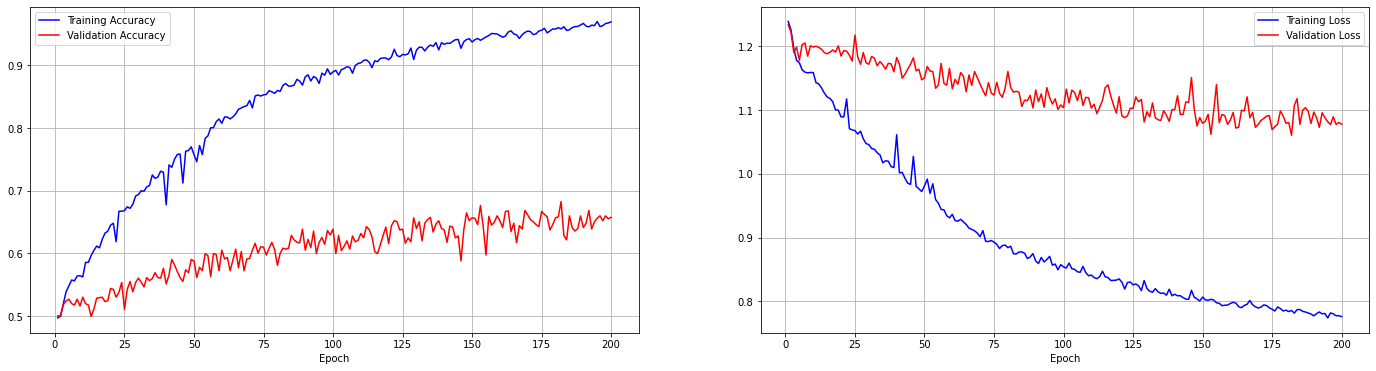

Best Validation Accuracy Score 0.68256, is for epoch 182


In [10]:
plot_results(history)
best_epoch = get_best_epcoh(history)